**Welcome** to this project report in Comppy17 given by Sese autumn 2017! Before you do anything, import these packages:

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline
from src import SimClass as simc
from src import laplace_solver as ls

# Solving Laplace's equation with boundary integral methods

In this project, we show how to solve Laplace's equation with a boundary integral equation (BIE) method as in [Atkinson]. One inherent complication with BIEs is the evaluation of so-called nearly-singular integrals. Here, we will also show how to obtain accurate solutions in the entire domain using a special quadrature [Helsing, Ojala].


All implementations for this project are in Python 3.6, and can be accessed through Git [here](https://github.com/aggimemnon/comppy17).

## Introduction
Here follows a (very) short introduction to how to reformulate Laplace's equation to a boundary integral equation. For a more comprehensive explanation, see [Atkinson].

We are considering Laplace's equation in two dimensions on some domain $\Omega$ with boundary $\delta\Omega$. Laplace's equation has the form
\begin{equation}
    \begin{cases}
        \Delta {u} &= 0 \text{ in } \Omega, \\
        {u} &= f \text{ on } \delta\Omega
    \end{cases}
\end{equation}

For the purpose of this example, we will consider a boundary condition $f$ that is **analytic**. Here, it will have the form 
\begin{equation}
    f(z) = \sum_i \dfrac{1}{z-z_i^s}, \text{ for } z\in\delta\Omega,
\end{equation}
where $z^s_i\notin\Omega\cup\Gamma$ are source points outside of the domain $\Omega$. In the case of $f$ analytic, the exact solution ${u}(z) = f(z)$, for $z\in\Omega$. This is a convenient way of checking numerical errors. 

## Discretisation
To solve this problem numerically and compute $u(\widehat{z}_i)$ for some discretization points $\widehat{z}_i$ in $\Omega$, we need to first obtain a good discretisation $z_i$ of the interface $\delta\Omega$. In order to get good approximations of the integrals in our formulation, we will use composite Gauss-Legendre quadrature. This means that we divide the boundary into panels of equal arc-length, $N_p$, and discretise each panel with 16 Gauss-Legendre points. To do this, we need a parametrisation of our interface $z(t)$, where $t\in[0,2\pi]$.

Before introducing the boundary integral formulation and numerical method, we will plot an example of a domain $\Omega$, as well as the boundary condition $f(z)$, $z\in\delta\Omega$ and an exact solution $u(\widehat{z})$, $\widehat{z}\in\Omega$. To do this, we need to introduce the *simulation class* of our project:

#### Simulation class
The simulation class *SimClass* handles all parameters and variables set for a specific simulation. Given an input data tuple, it will set up all discretisations needed to solve the equation. If no input is given, some default parameters are set. 

To demonstrate our domain and solution, we create a simulation class called *sc*. The indata tuple contains information about (in order) number of panels on interface $N_p$, shape of interface, radius of interface, number of source points, then source points $z_i^s$ and finally density of domain discretisation. The interface $\delta\Omega$ is marked in black, and the panel edges are marked with blue diamonds, and the source points are marked with red stars.

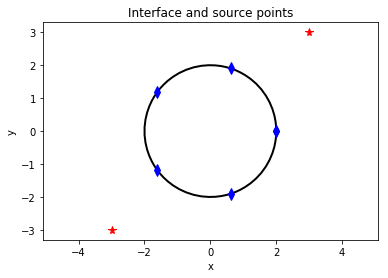

In [10]:
indata = [5, 'circle', 2, 2, 3+3j, -3-3j, 'medium']
sc = simc.SimClass(indata)
sc.setUp()

fig,ax = sc.plotInterface()
sc.plotPanels(ax)
sc.plotSources(ax)
plt.title('Interface and source points')
plt.show()

Between the panel edges marked with blue diamonds, we will discretise the interface with our Gauss-Legendre points. These points can be computed with the function *gaussLeg*. One of the characteristics of Gauss-Legendre points is that the nodes are non-equidistant, and cluster towards the edges of the interval. To demonstrate this we show the 16th order Gauss-Legendre nodes on the interval $[0,\frac{\pi}{2}]$ mapped to the first quadrant of the unit circle:

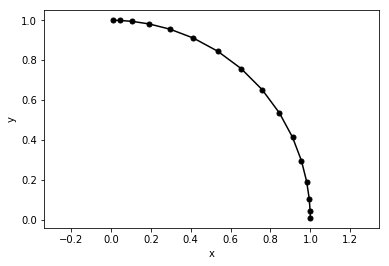

In [11]:
n,w = sc.gaussLeg(16,0,0.5*math.pi)
zn = np.cos(n)+1j*np.sin(n)

fig,ax = plt.subplots()
line = ax.plot(np.real(zn),np.imag(zn),'k.-',markersize=10)
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

On our circle domain from above, the discretisation with 5 panels will be

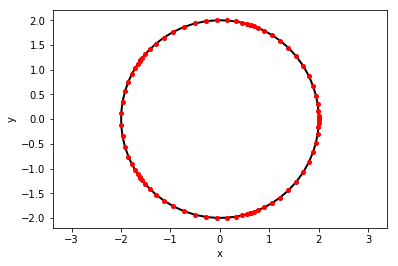

In [12]:
fig,ax = sc.plotInterface()
line = ax.plot(np.real(sc.zDrops),np.imag(sc.zDrops),'r.',markersize=8)

For this interface setup, we can also plot the exact solution $u^\ast(z)$ to Laplace's equation inside our domain. 

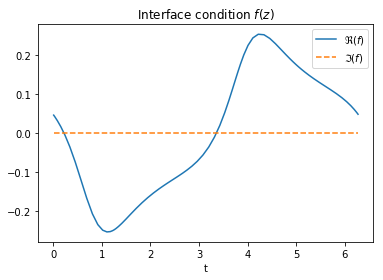

In [13]:
fig,ax = sc.plotRHS()
plt.title('Interface condition $f(z)$')
plt.show()

Computing correct solution...


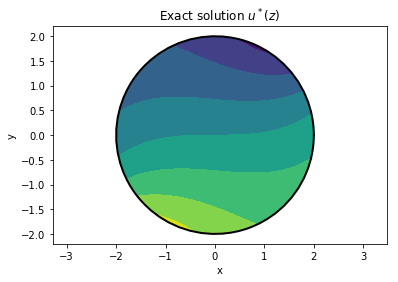

In [14]:
fig,ax = sc.plotInterface()
ls.plotSolution(sc,ax)
plt.title('Exact solution $u^*(z)$')
plt.show()

## Boundary integral formulation
To compute $u(z)$ in the domain $\Omega$ using a boundary integral formulation, we first need to compute an artifical density $\mu(z)$ on $\delta\Omega$, as 
\begin{equation}
    \frac{1}{2}\mu(z) + \frac{1}{2\pi}\int_{\partial\Omega} \mu(\tau)\Im\left\{ \dfrac{d\tau}{\tau-z} \right\} = f(z), \; z\in\delta\Omega.
\end{equation}
The attentive reader will see that for points $z=\tau$ the integral contain a singularity. Luckily, the integrals are well-defined, and we have the limit
\begin{equation}
    \lim_{\tau\rightarrow z} \Im\left\{ \dfrac{\tau^\prime}{\tau-z} \right\} = \Im\left\{ \dfrac{\tau^{\prime\prime}}{2\tau^\prime} \right\}.
\end{equation}
Once $\mu(z)$ is obtained for all interface points $z\in\delta\Omega$, the solution $u(z)$ can be computed everywhere in the domain $\Omega$ as 
\begin{equation}
    u(z) = \frac{1}{2\pi}\int_{\delta\Omega} \mu(\tau)\Im\left\{ \dfrac{d\tau}{\tau-z}\right\}.
\end{equation}

### Discretising the integrals
We discretise our integrals using the composite Gauss-Legendre quadrature from above. A generic integral is then approximated as
\begin{equation}
    \int_{\delta\Omega} k(\tau) d\tau \approx \sum_i w_i k_i \tau_i^\prime,
\end{equation}
where $k_i \approx k(\tau_i)$ and $\tau_i$, $i=1,..., N$ are the interface discretisation points. The associated Gauss-Legendre weights to $z_i$ are $w_i$.

For any $z_i\in\delta\Omega$, to find $\mu(z_i)\approx \mu_i$ is then approximated by 
\begin{equation}
    \frac{1}{2}\mu_i + \frac{1}{2\pi}\sum_{k=1}^N w_k \mu_k \Im\left\{ \dfrac{z^\prime_k}{z_k-z_i}\right\} = f_i
\end{equation}
Defining $\tilde{\,\mu\;} = (\mu_1 ... \mu_N)^T$ and $\tilde{\,f\;} = (f_1 ... f_N)^T$, this is equal to solving the system
\begin{equation}
    K\tilde{\,\mu\;} = \tilde{\,f\;},
\end{equation}
where $K$ is defined as
\begin{equation}
    \begin{cases}
        K_{ik} &= \frac{1}{2\pi}w_k\mu_k \Im\left\{ \dfrac{z_k^\prime}{z_k-z_i}\right\}, \; i\neq k \\ 
        K_{ii} &= \frac{1}{2}\mu_i + \frac{1}{2\pi}w_i\mu_i\Im\left\{ \dfrac{z_i^{\prime\prime}}{2z_i^\prime} \right\}. 
    \end{cases}
\end{equation}

In the same manner, discretising the intergral for computing $u(z)$ we get
\begin{equation}
    u(z) \approx \frac{1}{2\pi}\sum_k w_k \mu_k \Im\left\{ \dfrac{z^\prime_k}{z_k-z}\right\}, \; z\in\Omega\cup\delta\Omega.
\end{equation}

There are several advantages to using a boundary integral formulation like the one above to solve an elliptic equation. Firstly, as you only need to solve a system on the boundary of your domain you decrease the degrees of freedoms of your problem and obtain a smaller system to solve than if you had discretised the entire domain. Furthermore, the integral equation to compute $\mu(z)$ is a so-called Fredholm equation of the second kind, which means the system will be well-conditioned. This is beneficial, as iterative solvers will converge quickly.

## Solving Laplace's equation
We have created a separate class to solve the equation, called *laplace_solver*. This class constructs a discretisation $z_i$ using *SimClass* and contains functions for computing both $\mu(z_i)$ and $u(z)$ for $z\in\Omega$.

The first thing one needs to do is to define the parameters needed as indata, and then set up the simulation through the function *setUpSim*. One can then easily compute the density through *compDensity* from the module *laplace_solver*:

Defining simulation...
Setting up domain...
Computing density...
GMRES converged succesfully.


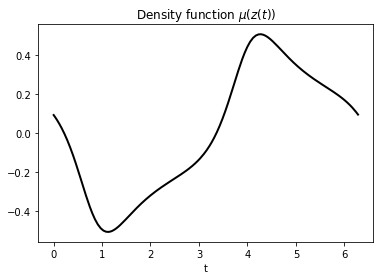

In [15]:
indata = [10, 'circle', 2, 2, 3+3j, -3-3j, 'medium']
sc = ls.setUpSim(indata) #Set up simulation
mu = ls.compDensity(sc) #Compute density 

# Plot density
fig, ax = plt.subplots()
mul = ax.plot(sc.tDrops,mu,'k-',linewidth=2)
ax.set_xlabel('t')
plt.title('Density function $\mu(z(t))$')
plt.show()

Once the density $\mu(z_i)$, $z_i\in\delta\Omega$, is obtained, you can compute the solution to Laplace's equation. With the composite 16-point Gauss-Legendre quadrature, this is done by *compSolStandard* in the *laplace_solver* module.

When the solution has been computed we can compute the errors by comparing to our exact solution $u(z)=f(z)$ for all $z\in\Omega$. This is done by the function *compError* in *laplace_solver*.  

Computing correct solution...
Computing u with standard quadrature...
Computing errors...


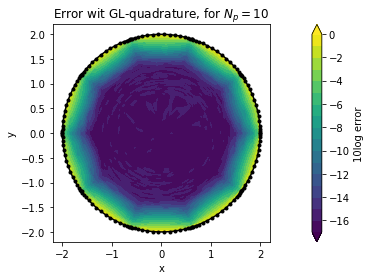

In [16]:
ucorrect = ls.compSolCorrect(sc) #Compute exact solution
u = ls.compSolStandard(sc,mu) #Compute u with standard 16point composite GL
est, esp = ls.compError(sc,u,'',ucorrect) #Compute error of u

# Plot error
fig, ax = ls.plotError(sc,est)
plt.title('Error wit GL-quadrature, for $N_p=${}'.format(sc.nbr_panels))
plt.show()

We see that the errors in $u(z)$ are **quite large**, as displayed by the above plot. The intuitive way to decrease such errors, would be to improve the discretisation, with a larger number of Gauss-Legendre panels $N_p$. However, this does not solve all our problems:

Defining simulation...
Setting up domain...
Computing density...
GMRES converged succesfully.
Computing correct solution...
Computing u with standard quadrature...
Computing errors...


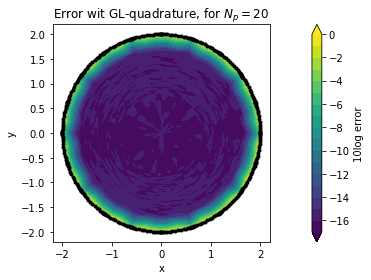

In [17]:
# Compute the solution to Laplace's equation again, but with larger number of panels
indata = [20, 'circle', 2, 2, 3+3j, -3-3j, 'medium']
sc = ls.setUpSim(indata) #Set up simulation
mu = ls.compDensity(sc) #Compute density 
ucorrect = ls.compSolCorrect(sc) #Compute exact solution
u = ls.compSolStandard(sc,mu) #Compute u with standard 16point composite GL
est, esp = ls.compError(sc,u,'',ucorrect) #Compute error of u

# Plot error
fig, ax = ls.plotError(sc,est)
plt.title('Error wit GL-quadrature, for $N_p=${}'.format(sc.nbr_panels))
plt.show()


We see here that by increasing the discretisation with a factor two, still yields a solution with very large errors close to the boundary of our domain. Why is this?

### Nearly singular integrals
When evaluating our integrals at a point $z\in\Omega$ which is close to the interface, that means that for some (or more) discretisation point $\tau_i \in\delta\Omega$ the distance between the two points is very small, $|z-\tau_i| <<1$. 

Studying our boundary integral formulation, we see that it contain terms of the type
\begin{equation}
    \dfrac{\tau_i^\prime}{\tau_i-z}.
\end{equation}
When the denominator gets very small, as is the case when $z\rightarrow \delta\Omega$, this introduces cancellation erros and we get large numerical errors even though the problem is well-defined mathematically with a limit as $z=\tau_i$. Thus, to solve our equation to a high accuracy on the **entire domain**, we need to do something more.

## Special quadrature
This approach, also called Helsing quadrature, was orginially developed by [Helsing,Ojala] - and they give a much more detailed description. A short summary follows here. When evaluating an integral of the form
\begin{equation}
    u(z) = \int_{\delta\Omega} \mu(\tau) \Im\left\{ \dfrac{d\tau}{\tau-z} \right\}
\end{equation}
we rewrite it into an expression that we can evaluate without the near-singularity. The first thing to do is to take out the integral over the panel $P_j$ which the point $z$ is close to. In the case of the integral above, the expression we can evaluate is 
\begin{equation}
    p_k(z) = \int_{P_j} \dfrac{\tau^k}{\tau-z}d\tau, \; k=0,...,N,
\end{equation}
where we can compute $p_k$ through a simple recursion and $p_0(z) = \log(1-z)-\log(-1-z)$.

To use these $p_k$ in our integral over $P_j$ for $u(z)$, $u^j(z)$, we need to reformulate it somewhat. The first thing to do is to interpolate $\mu(z)\approx \sum_{i=0}^{16}c_i\tau^i$ on the panel $P_j$. The integral of $u^j(z)$ then becomes
\begin{equation}
    u^j(z) = \int_{P_j} \mu(z) \Im\left\{ \dfrac{d\tau}{\tau-z} \right\} \approx \int_{P_j} \sum_{i=0}^{16} c_i \tau^i\Im\left\{ \dfrac{d\tau}{\tau-z} \right\}.
\end{equation}
From this we can further reformualte the integral until we obtain
\begin{equation}
    u^j(z) \approx \Im\left\{ \sum_{i=0}^{16} c_i \int_{P_j} \tau^i \dfrac{d\tau}{\tau-z} \right\} = \Im\left\{ \sum_{i=0}^{16} c_i p_i \right\}.
\end{equation}
Thus, for any point-panel pair $z, \; P_j$ we can compute the monomials $p_i$ and the interpolation of $\mu(z)$ on $P_j$, and then the integral over the panel $P_j$ is simply the sum of the coefficients, $c_i$ and $p_i$.

To demonstrate the results of this special quadrature approach, we can again compute the full integral $u(z)$ and compare to the exact solution. 

Defining simulation...
Setting up domain...
Computing density...
GMRES converged succesfully.
Computing correct solution...
Computing u with standard quadrature...
Computing u with special quadrature...
Computing errors...


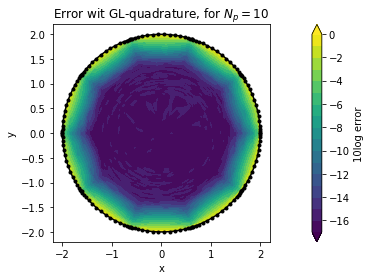

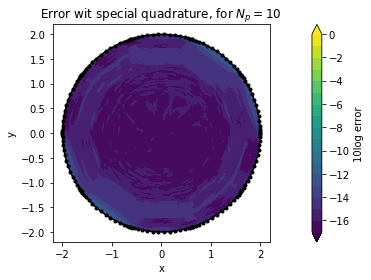

In [18]:
# Compute the solution to Laplace's equation again, but with larger number of panels
indata = [10, 'circle', 2, 2, 3+3j, -3-3j, 'medium']
sc = ls.setUpSim(indata) #Set up simulation
mu = ls.compDensity(sc) #Compute density 
ucorrect = ls.compSolCorrect(sc) #Compute exact solution
u = ls.compSolStandard(sc,mu) #Compute u with standard 16point composite GL
usc = ls.compSolSpecial(sc,mu,u) # Compute u with special quadrature when needed
est, esp = ls.compError(sc,u,usc,ucorrect) #Compute error of u

# Plot error
fig,ax = ls.plotError(sc,est)
plt.title('Error wit GL-quadrature, for $N_p=${}'.format(sc.nbr_panels))
plt.show()

fig,ax = ls.plotError(sc,esp)
plt.title('Error wit special quadrature, for $N_p=${}'.format(sc.nbr_panels))
plt.show()

## Algorithm and implementation
For this project, Python code to solve Laplace's equation and an algorithm for the special quadrature has been implemented. As previously mentioned, all variables are contained in one class, *SimClass*, which contains all parameters needed and has methods to discretise domain and interface, as well as computing the boundary condition. The methods to compute the exact solution, solve the linear system to compute the density $\mu$ and to compute $u$ are all kept in the module *laplace_solver*. If you would like to run the code outside of this notebook, that can be done by running the module *laplace_run*, which sets up a simulation and plots the result.

The main packages needed for this method is *math*, as $\pi$ is needed, *numpy* for handling of arrays, complex numbers and functions such as $\cos$ and $\exp$ and also *scipy* to solve the linear system †o compute $\mu$ with gmres. Furthermore, *matplotlib* is used for plotting of results.

## Testing
In order to test our framework, we have also implemented some tests within the *pytest* framework. The tests for *SimClass* are contained in the module *test_SimClass*, and those for *laplace_solver* in *test_laplaceSolver*. To run these, in main folder do

    python -m pytest tests/

in the *src* directory. For reports on coverage, instead do 

    python -m pytest tests/ --cov --cov-report=html
    open htmlconv/index.html
    
This will display what parts of the code are covered by the tests.

## Version control
As previously mentioned, all source code for this project is available on Git. In this project, Git have been used very rudimentary, without branching or merging between different computers. 

The public repository on GitHub has been connected to both Travis CI and and Coveralls through webhooks. To see the current status of the build, follow the badges on [Github](https://github.com/aggimemnon/comppy17).

## Summary
In this project we implemented the algorithms to solve Laplace's equation accurately with a boundary integral method. We tried to utilise different Python features such as classes, vectorised operations and some well-known modules as *numpy* and *scipy*. We also investigated different ways of plotting our results and how to read data from files.  

## References

 - [Atkinson]: K.E. Atkinson, *Numerical Solution of Integral Equations of the Second Kind*,  Cambridge University Press, 1997
 - [Helsing, Ojala]: J. Helsing and R. Ojala, *On the evaluation of layer potentials close to their sources*, Journal of Computational Physics, 2008
 
### This project is done by Sara Pålsson and code distributed under MIT license